In [446]:
!pip install ipdb 
!pip install transformers
!pip install optuna

# Package loading 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

import ipdb
import spacy
spacy.load("en_core_web_sm")
import torch
from torchtext import data
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from transformers import RobertaTokenizer, BertTokenizer, BertModel, TransfoXLTokenizer, TransfoXLModel

import optuna
from sklearn.model_selection import KFold, StratifiedKFold

# Data Exploration

In [2]:
train = pd.read_csv("./data/Train_process.csv")
test = pd.read_csv("./data/Test_process.csv")

sample = pd.read_csv("./data/SampleSubmission.csv")
y_kfold = train.label.values # this is used down in the the kfold

In [3]:
train.tail()

,ID,text,label
611,BOHSNXCN,what should i do to stop alcoholism ?,Alcohol
612,GVDXRQPY,how to become my oneself again,Suicide
613,IO4JHIQS,how can someone stop it ?,Alcohol
614,1DS3P1XO,i feel unworthy,Depression
615,ORF71PVQ,i feel so discouraged with life,Depression


In [450]:
# check = pd.read_csv("./data/Test.csv")

616

In [451]:
# check.text.values

Let check the distribution of the data. 

In [452]:
test.tail()

,ID,text
304,Z9A6ACLK,yes
305,ZDUOIGKN,my girlfriend dumped me
306,ZHQ60CCH,how can i go back to being my old self ?
307,ZVIJMA4O,is it true hang is medicinal ?
308,ZYIFAY98,how can i overcome the problem ?


In [453]:
sample.tail()

,ID,Depression,Alcohol,Suicide,Drugs
304,Z9A6ACLK,0,0,0,0
305,ZDUOIGKN,0,0,0,0
306,ZHQ60CCH,0,0,0,0
307,ZVIJMA4O,0,0,0,0
308,ZYIFAY98,0,0,0,0


In [454]:
train.label.value_counts()

Depression    352
Alcohol       140
Suicide        66
Drugs          58
Name: label, dtype: int64

In [455]:
list(np.unique(train.label))

['Alcohol', 'Depression', 'Drugs', 'Suicide']

In [5]:
len(train)

616

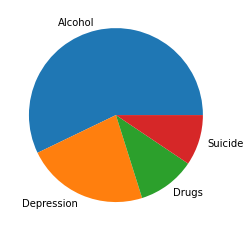

In [456]:
# This plot need to be checked 
plt.pie(list(train.label.value_counts()), labels=list(np.unique(train.label)))
plt.show()

In [457]:
list(np.unique(train.label))

['Alcohol', 'Depression', 'Drugs', 'Suicide']

In [458]:
def_len = lambda x: len(x)

In [459]:
# train['len'] = train.text.apply(def_len)

In [460]:
# train.text.values

In [461]:
# train.len.value_counts()

In [462]:
# # This plot need to be checked 
# plt.pie(list(train.len.value_counts()), labels=list(np.unique(train.len)))
# plt.show()

## Preparing Data

One of the main concepts of TorchText is the `Field`. These define how your data should be processed. In our sentiment classification task the data consists of both the raw string of the review and the sentiment, either "pos" or "neg".

The parameters of a `Field` specify how the data should be processed. 

We use the `TEXT` field to define how the review should be processed, and the `LABEL` field to process the sentiment. 

Our `TEXT` field has `tokenize='spacy'` as an argument. This defines that the "tokenization" (the act of splitting the string into discrete "tokens") should be done using the [spaCy](https://spacy.io) tokenizer. If no `tokenize` argument is passed, the default is simply splitting the string on spaces.

`LABEL` is defined by a `LabelField`, a special subset of the `Field` class specifically used for handling labels. We will explain the `dtype` argument later.

For more on `Fields`, go [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py).

We also set the random seeds for reproducibility.

In [463]:
train.head()

,ID,text,label
0,SUAVK39Z,i feel that it was better i die am happy,Depression
1,9JDAGUV3,why do i get hallucinations ?,Drugs
2,419WR1LQ,i am stressed due to lack of financial support...,Depression
3,6UY7DX6Q,why is life important ?,Suicide
4,FYC0FTFB,how could i be helped to go through the depres...,Depression


In [464]:
# label_test = le.transform(test.label)

# test['label'] = label_test

In [465]:
test.tail()

,ID,text
304,Z9A6ACLK,yes
305,ZDUOIGKN,my girlfriend dumped me
306,ZHQ60CCH,how can i go back to being my old self ?
307,ZVIJMA4O,is it true hang is medicinal ?
308,ZYIFAY98,how can i overcome the problem ?


In [466]:
sample.head()

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0,0,0,0
1,03BMGTOK,0,0,0,0
2,03LZVFM6,0,0,0,0
3,0EPULUM5,0,0,0,0
4,0GM4C5GD,0,0,0,0


In [467]:
# RobertaTokenizer.from_pretrained??

In [468]:
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base') # roberta-base, bert-base-uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = TransfoXLTokenizer.from_pretrained('transfo-xl-wt103')

init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [469]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [470]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# TEXT = data.Field(tokenize = 'spacy')
LABELS = data.LabelField(dtype = torch.float)

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
#                   tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

In [471]:
train_data, test_data= data.TabularDataset.splits(
    path='./data', train='Train_process.csv',
    test='Test_process.csv', format='csv', skip_header=True,
    fields=[('ID', None),
            ('text', TEXT),
            ('label', LABELS)])


# train_data = data.TabularDataset.splits(
#     path='./data', train='Train.csv',
#     format='csv', skip_header=True,
#     fields=[('ID', None),
#             ('text', TEXT),
#             ('label', LABEL)])

# test_data = data.TabularDataset.splits(
#     path='./data', test='Test.csv', format='csv', 
#     skip_header=True,
#     fields=[('ID', None),
#             ('text', TEXT)])

# train_iter, val_iter, test_iter = data.BucketIterator.splits(
#     (train, val, test), batch_sizes=(16, 256, 256),
#     sort_key=lambda x: len(x.text), device=0)

# TEXT.build_vocab(train)
# LABELS.build_vocab(train)

In [472]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 616
Number of testing examples: 309


Let check one example

In [473]:
print(vars(train_data.examples[0]))

{'text': [1045, 2514, 2008, 2009, 2001, 2488, 1045, 3280, 2572, 3407], 'label': 'Depression'}


In [474]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[0])['text'])

print(tokens)

['i', 'feel', 'that', 'it', 'was', 'better', 'i', 'die', 'am', 'happy']


## Split 

In [475]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED), 
                                          stratified=True, split_ratio=0.8)

In [476]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 493
Number of validation examples: 123
Number of testing examples: 309


In [477]:
# MAX_VOCAB_SIZE = 700   # 751

# # TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
# # LABEL.build_vocab(train_data)

# # MAX_VOCAB_SIZE = 25_000

# TEXT.build_vocab(train_data, 
#                  max_size = MAX_VOCAB_SIZE, 
#                  vectors = "glove.6B.100d", 
#                  unk_init = torch.Tensor.normal_)

LABELS.build_vocab(train_data)

In [478]:
# print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABELS.vocab)}")

Unique tokens in LABEL vocabulary: 4


In [479]:
print(LABELS.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fe1fc769bf8>, {'Depression': 0, 'Alcohol': 1, 'Suicide': 2, 'Drugs': 3})


In [480]:
# print(TEXT.vocab.freqs.most_common(20))

In [481]:
# print(TEXT.vocab.itos[:10])

In [482]:
print(vars(valid_data.examples[-1]))

{'text': [2129, 2000, 4468, 6544], 'label': 'Alcohol'}


The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

We'll use a BucketIterator which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

We also want to place the tensors returned by the iterator on the GPU (if you're using one). PyTorch handles this using torch.device, we then pass this device to the iterator.

In [483]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort=False,
    device = device)

# train_iterator, test_iterator = data.BucketIterator.splits(
#     (train_data, test_data), 
#     batch_size = BATCH_SIZE,
#     sort=False,
#     device = device)

In [484]:
# next(test_iterator.__iter__())

# Build the Model

In [485]:
from transformers import RobertaModel, BertModel

In [486]:
# model = RobertaModel.from_pretrained('roberta-base') # bert-base-cased, bert-large-cased
model = BertModel.from_pretrained('bert-base-uncased')
# model = TransfoXLModel.from_pretrained('transfo-xl-wt103')

In [487]:
# class BERTLinearSentiment(nn.Module):
#     def __init__(self,
#                  bert,
#                  hidden_dim,
#                  output_dim,
#                  n_layers,
#                  bidirectional,
#                  dropout):
        
#         super().__init__()
        
#         self.bert = bert
        
#         embedding_dim = bert.config.to_dict()['hidden_size']
        
#         self.lin_1 = nn.Linear(768, 500)
#         self.linear_out = nn.Linear(500, output_dim)
        
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, text):
        
#         #text = [batch size, sent len]
                
#         with torch.no_grad():
# #             ipdb.set_trace()
#             embedded = self.bert(text)[1]
        
#         output = self.dropout(self.linear_out(self.dropout(self.lin_1(embedded))))
        
#         #output = [batch size, out dim]
        
#         return F.sigmoid(output) #torch.sigmoid(output) # the output between 0 and 1

In [488]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
#         ipdb.set_trace()
        with torch.no_grad():
#             ipdb.set_trace()
            embedded = self.bert(text)[0]
                
#         embedded = [batch size, sent len, emb dim]
                
        _, hidden = self.rnn(embedded)
        
#         hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
#         ipdb.set_trace()
        output = self.linear(hidden)
                
        #output = [batch size, out dim]
        
        return output # F.sigmoid(output) # the output between 0 and 1

In [489]:
# # can view the summary if you like
# model.to(device)
# summary(model, (16, 32))

In [490]:
# MAX_VOCAB_SIZE = 25_000

# TEXT.build_vocab(train_data, 
#                  max_size = MAX_VOCAB_SIZE, 
#                  vectors = "glove.6B.100d", 
#                  unk_init = torch.Tensor.normal_)

# LABEL.build_vocab(train_data)

In [491]:
# INPUT_DIM = len(TEXT.vocab)
# EMBEDDING_DIM = 100
# N_FILTERS = 100
# FILTER_SIZES = [2,3,4]
# OUTPUT_DIM = len(LABEL.vocab)
# DROPOUT = 0.5
# PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

HIDDEN_DIM = 500
OUTPUT_DIM = len(LABELS.vocab)
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.3

model = BERTGRUSentiment(model,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

Let's also create a function that will tell us how many trainable parameters our model has so we can compare the number of parameters across different models.

In [492]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,892,244 trainable parameters


In [493]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [494]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,410,004 trainable parameters


In [495]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
linear.weight
linear.bias


# Train the model

Next, we'll load our pre-trained embeddings.

Another different to the previous notebooks is our loss function (aka criterion). Before we used `BCEWithLogitsLoss`, however now we use `CrossEntropyLoss`. Without going into too much detail, `CrossEntropyLoss` performs a *softmax* function over our model outputs and the loss is given by the *cross entropy* between that and the label.

Generally:
- `CrossEntropyLoss` is used when our examples exclusively belong to one of $C$ classes
- `BCEWithLogitsLoss` is used when our examples exclusively belong to only 2 classes (0 and 1) and is also used in the case where our examples belong to between 0 and $C$ classes (aka multilabel classification).

In [496]:
from collections import Counter
class_distrbution = Counter()
for text in train["label"].values:
    class_distrbution[text] += 1
        
class_distrbution.most_common(10)

[('Depression', 352), ('Alcohol', 140), ('Suicide', 66), ('Drugs', 58)]

In [497]:
np.sum(list(class_distrbution.values()))

616

In [498]:
class_distrbution

Counter({'Alcohol': 140, 'Depression': 352, 'Drugs': 58, 'Suicide': 66})

In [499]:
LABELS.vocab.stoi.keys()

dict_keys(['Depression', 'Alcohol', 'Suicide', 'Drugs'])

In [500]:
# criterion = nn.CrossEntropyLoss(weight = x)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_loader_origin.dataset.classes,
class_weights = [class_distrbution[i] for i in LABELS.vocab.stoi.keys()]
class_weights_normalized = [max(class_weights)/i for i in class_weights]

class_weights_normalized ,torch.Tensor(class_weights_normalized)

w = torch.Tensor(class_weights_normalized)
w = w.to(device)
# x = x
w,class_distrbution

(tensor([1.0000, 2.5143, 5.3333, 6.0690]),
 Counter({'Alcohol': 140, 'Depression': 352, 'Drugs': 58, 'Suicide': 66}))

In [501]:
class_weights, w

([352, 140, 66, 58], tensor([1.0000, 2.5143, 5.3333, 6.0690]))

In [502]:
# optim.Adam?

In [503]:
import torch.optim as optim

# optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum=0.9, 
#                       weight_decay=0, dampening=0, nesterov=True)

# optimizer = optim.Adam(model.parameters(), lr = 1e-4, betas=(0.9, 0.999), 
#                       weight_decay=0.0, amsgrad=False)

optimizer = optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss(weight=w)
criterion = nn.CrossEntropyLoss()

# criterion = nn.CrossEntropyLoss()
# model = BERTGRUSentiment(model,
#                          HIDDEN_DIM,
#                          OUTPUT_DIM,
#                          N_LAYERS,
#                          BIDIRECTIONAL,
#                          DROPOUT)

model = model.to(device)
criterion = criterion.to(device)

Before, we had a function that calculated accuracy in the binary label case, where we said if the value was over 0.5 then we would assume it is positive. In the case where we have more than 2 classes, our model outputs a $C$ dimensional vector, where the value of each element is the beleief that the example belongs to that class. 

For example, in our labels we have: 'HUM' = 0, 'ENTY' = 1, 'DESC' = 2, 'NUM' = 3, 'LOC' = 4 and 'ABBR' = 5. If the output of our model was something like: **[5.1, 0.3, 0.1, 2.1, 0.2, 0.6]** this means that the model strongly believes the example belongs to class 0, a question about a human, and slightly believes the example belongs to class 3, a numerical question.

We calculate the accuracy by performing an `argmax` to get the index of the maximum value in the prediction for each element in the batch, and then counting how many times this equals the actual label. We then average this across the batch.

In [504]:
from sklearn.metrics import accuracy_score, precision_score

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    
    correct = max_preds.squeeze(1).eq(y)
#     ipdb.set_trace()
    pr = correct.sum().item() / torch.FloatTensor([y.shape[0]])
    
#     pr = precision_score(y.detach().numpy(), 
#                            max_preds.argmax(dim = 1, 
#                                         keepdim = True).detach().numpy(), average='macro')
#     ipdb.set_trace()
    return pr

The training loop is similar to before, without the need to `squeeze` the model predictions as `CrossEntropyLoss` expects the input to be **[batch size, n classes]** and the label to be **[batch size]**.

The label needs to be a `LongTensor`, which it is by default as we did not set the `dtype` to a `FloatTensor` as before.

In [505]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        
        predictions = model(batch.text)
#         ipdb.set_trace()
        
        loss = criterion(predictions, batch.label.long())
        
        acc = categorical_accuracy(predictions, batch.label.long())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluation loop is, again, similar to before.

In [506]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text)
            
            loss = criterion(predictions, batch.label.long())
            
            acc = categorical_accuracy(predictions, batch.label.long())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [507]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Next, we train our model.

In [508]:
N_EPOCHS = 10

best_valid_loss = 0.30 #float('inf')
best_valid_acc = 0.88

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    if valid_loss < best_valid_loss and abs(valid_loss - best_valid_loss) < 1e-1:
        best_valid_loss = valid_loss
        print('Saving Model ...')
        torch.save(model.state_dict(), 'Model_Bert_'+str(best_valid_loss)[:4]+'.pt')
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, valid_loss, valid_acc))
        print('*****************************************************')

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.316 | Train Acc: 49.47%
	 Val. Loss: 1.264 |  Val. Acc: 54.69%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.118 | Train Acc: 56.10%
	 Val. Loss: 1.217 |  Val. Acc: 54.69%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.982 | Train Acc: 62.14%
	 Val. Loss: 1.159 |  Val. Acc: 61.95%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 0.761 | Train Acc: 72.10%
	 Val. Loss: 0.563 |  Val. Acc: 78.33%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.606 | Train Acc: 77.16%
	 Val. Loss: 0.477 |  Val. Acc: 84.43%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.441 | Train Acc: 83.52%
	 Val. Loss: 0.350 |  Val. Acc: 84.43%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.333 | Train Acc: 88.01%
	 Val. Loss: 0.474 |  Val. Acc: 82.38%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 0.438 | Train Acc: 85.38%
	 Val. Loss: 0.405 |  Val. Acc: 85.71%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 0.306 | Train Acc: 88.48%
	 Val. Loss: 0.363 |  Val. Acc: 87.36%
Epoch: 10 | Epoch T

In [ ]:
# Epoch: 01 | Epoch Time: 0m 24s
# 	Train Loss: 1.316 | Train Acc: 49.47%
# 	 Val. Loss: 1.264 |  Val. Acc: 54.69%
# Epoch: 02 | Epoch Time: 0m 23s
# 	Train Loss: 1.118 | Train Acc: 56.10%
# 	 Val. Loss: 1.217 |  Val. Acc: 54.69%
# Epoch: 03 | Epoch Time: 0m 24s
# 	Train Loss: 0.982 | Train Acc: 62.14%
# 	 Val. Loss: 1.159 |  Val. Acc: 61.95%
# Epoch: 04 | Epoch Time: 0m 24s
# 	Train Loss: 0.761 | Train Acc: 72.10%
# 	 Val. Loss: 0.563 |  Val. Acc: 78.33%
# Epoch: 05 | Epoch Time: 0m 24s
# 	Train Loss: 0.606 | Train Acc: 77.16%
# 	 Val. Loss: 0.477 |  Val. Acc: 84.43%
# Epoch: 06 | Epoch Time: 0m 24s
# 	Train Loss: 0.441 | Train Acc: 83.52%
# 	 Val. Loss: 0.350 |  Val. Acc: 84.43%
# Epoch: 07 | Epoch Time: 0m 23s
# 	Train Loss: 0.333 | Train Acc: 88.01%
# 	 Val. Loss: 0.474 |  Val. Acc: 82.38%
# Epoch: 08 | Epoch Time: 0m 24s
# 	Train Loss: 0.438 | Train Acc: 85.38%
# 	 Val. Loss: 0.405 |  Val. Acc: 85.71%
# Epoch: 09 | Epoch Time: 0m 24s
# 	Train Loss: 0.306 | Train Acc: 88.48%
# 	 Val. Loss: 0.363 |  Val. Acc: 87.36%
# Epoch: 10 | Epoch Time: 0m 23s
# 	Train Loss: 0.218 | Train Acc: 92.29%
# 	 Val. Loss: 0.296 |  Val. Acc: 90.62%
# Epoch: 11 | Epoch Time: 0m 23s
# 	Train Loss: 0.160 | Train Acc: 94.73%
# 	 Val. Loss: 0.271 |  Val. Acc: 90.48%
# Epoch: 12 | Epoch Time: 0m 24s
# 	Train Loss: 0.132 | Train Acc: 95.42%
# 	 Val. Loss: 0.416 |  Val. Acc: 82.03%
# Epoch: 13 | Epoch Time: 0m 24s
# 	Train Loss: 0.102 | Train Acc: 95.91%
# 	 Val. Loss: 0.345 |  Val. Acc: 89.70%
# Epoch: 14 | Epoch Time: 0m 24s
# 	Train Loss: 0.060 | Train Acc: 97.37%
# 	 Val. Loss: 0.474 |  Val. Acc: 85.79%
# Epoch: 15 | Epoch Time: 0m 23s
# 	Train Loss: 0.062 | Train Acc: 96.98%
# 	 Val. Loss: 0.400 |  Val. Acc: 89.06%
# Epoch: 16 | Epoch Time: 0m 23s
# 	Train Loss: 0.072 | Train Acc: 96.78%
# 	 Val. Loss: 0.316 |  Val. Acc: 89.55%
# Epoch: 17 | Epoch Time: 0m 23s
# 	Train Loss: 0.087 | Train Acc: 97.07%
# 	 Val. Loss: 0.335 |  Val. Acc: 90.62%
# Epoch: 18 | Epoch Time: 0m 23s
# 	Train Loss: 0.102 | Train Acc: 96.59%
# 	 Val. Loss: 0.409 |  Val. Acc: 88.77%
# Epoch: 19 | Epoch Time: 0m 24s
# 	Train Loss: 0.049 | Train Acc: 98.83%
# 	 Val. Loss: 0.269 |  Val. Acc: 89.55%
# Epoch: 20 | Epoch Time: 0m 23s
# 	Train Loss: 0.030 | Train Acc: 99.22%
# 	 Val. Loss: 0.364 |  Val. Acc: 91.12%

In [382]:
abs(0.218-0.296) < 1e-1

True

# Cross Validation

In [358]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
#         self.linear2 = nn.Linear(500, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
#         ipdb.set_trace()
        with torch.no_grad():
#             ipdb.set_trace()
            embedded = self.bert(text)[0]
                
#         embedded = [batch size, sent len, emb dim]
                
        _, hidden = self.rnn(embedded)
        
#         hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
#         ipdb.set_trace()
        output = self.linear(hidden)
                
        # output = [batch size, out dim]
        
#         output = self.sigmoid(output)
        
        return output #torch.softmax(output, dim=1) # # the output between 0 and 1

In [536]:
class load_data(object):
    def __init__(self, SEED=1234):
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True

        tokenizer = RobertaTokenizer.from_pretrained('roberta-base') # roberta-base, bert-base-uncased
#         tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        init_token = tokenizer.cls_token
        eos_token = tokenizer.sep_token
        pad_token = tokenizer.pad_token
        unk_token = tokenizer.unk_token
        
        init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
        eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
        pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
        unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
        
        LABELS = data.LabelField(dtype = torch.float)

        TEXT = data.Field(batch_first = True,
                          use_vocab = False,
        #                   tokenize = tokenize_and_cut,
                          preprocessing = tokenizer.convert_tokens_to_ids,
                          init_token = init_token_idx,
                          eos_token = eos_token_idx,
                          pad_token = pad_token_idx,
                          unk_token = unk_token_idx)


#         self.train_data, self.test_data = datasets.IMDB.splits(TEXT, LABEL)
        
        self.train_data, self.test_data = data.TabularDataset.splits(
            path='./data', train='Train_process.csv',
            test='Test_process.csv', format='csv', skip_header=True,
            fields=[('ID', None),
                    ('text', TEXT),
                    ('label', LABELS)])

        self.SEED = SEED


    def get_fold_data(self, num_folds=10):
        """
        More details about 'fields' are available at 
        https://github.com/pytorch/text/blob/master/torchtext/datasets/imdb.py
        """

#         tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base') # roberta-base, bert-base-uncased
        
        init_token = tokenizer.cls_token
        eos_token = tokenizer.sep_token
        pad_token = tokenizer.pad_token
        unk_token = tokenizer.unk_token
        
        init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
        eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
        pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
        unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
        
        LABELS = data.LabelField(dtype = torch.float)

        TEXT = data.Field(batch_first = True,
                          use_vocab = False,
        #                   tokenize = tokenize_and_cut,
                          preprocessing = tokenizer.convert_tokens_to_ids,
                          init_token = init_token_idx,
                          eos_token = eos_token_idx,
                          pad_token = pad_token_idx,
                          unk_token = unk_token_idx)

        fields = [('text', TEXT), ('label', LABELS)]
        
#         kf = KFold(n_splits=num_folds, shuffle=True, random_state=self.SEED)
        kf = StratifiedKFold(n_splits=num_folds, random_state=self.SEED)
        
        train_data_arr = np.array(self.train_data.examples)

#         ipdb.set_trace()
        for train_index, val_index in kf.split(train_data_arr, y_kfold):
            yield(
                TEXT,
                LABELS,
                data.Dataset(train_data_arr[train_index], fields=fields),
                data.Dataset(train_data_arr[val_index], fields=fields),
            )
    
    def get_test_data(self):
        return self.test_data

In [537]:
data_generator = load_data()
_history = []
device = None
model = None
criterion = None
fold_index = 0
num_folds = 5
batch_size = 32
epochs = 10

import torch.optim as optim

# optimizer = optim.Adam(model.parameters())

best_valid_acc = 0.9
best_val_loss = 0.29

for TEXT, LABELS, train_data, val_data in data_generator.get_fold_data(num_folds=num_folds):
    print("***** Running Training *****")
    print(f"Now fold: {fold_index + 1} / {num_folds}")

#     print(f'Embedding size: {TEXT.vocab.vectors.size()}.')
    LABELS.build_vocab(train_data) # For converting str into float labels.

#     Model(len(TEXT.vocab), embedding_dim, hidden_dim,
#         output_dim, num_layers, dropout, TEXT.vocab.vectors, embedding_trainable)

    HIDDEN_DIM = 500
    OUTPUT_DIM = len(LABELS.vocab)
    N_LAYERS = 2
    BIDIRECTIONAL = False
    DROPOUT = 0.3
    
#     model = BertModel.from_pretrained('bert-base-uncased')
    model = RobertaModel.from_pretrained('roberta-base') # bert-base-cased, bert-large-cased

    model = BERTGRUSentiment(model,
                     HIDDEN_DIM,
                     OUTPUT_DIM,
                     N_LAYERS,
                     BIDIRECTIONAL,
                     DROPOUT)

    
    for name, param in model.named_parameters():                
        if name.startswith('bert'):
            param.requires_grad = False
        
#     def count_parameters(model):
#         return sum(p.numel() for p in model.parameters() if p.requires_grad)

#     print(f'The model has {count_parameters(model):,} trainable parameters')

    # Get w
    from collections import Counter
    class_distrbution = Counter()
    for text in y_kfold:
        class_distrbution[text] += 1


    class_weights = [class_distrbution[i] for i in LABELS.vocab.stoi.keys()]
    class_weights_normalized = [max(class_weights)/i for i in class_weights]


    w = torch.Tensor(class_weights_normalized)
    w = w.to(device)

    optimizer = optim.Adam(model.parameters())
#         criterion = nn.CrossEntropyLoss(weight=w)

#     optimizer = optim.SGD(model.parameters(), lr = lr, momentum=momentum, 
#                   weight_decay=0, dampening=0, nesterov=False)

#     optimizer = optim.Adam(model.parameters(), lr = 1e-3, betas=(0.9, 0.999), 
#                   weight_decay=0.0, amsgrad=False)

#     criterion = nn.CrossEntropyLoss(weight = w)
    criterion = nn.CrossEntropyLoss()



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)

    train_iterator = data.Iterator(train_data, batch_size=batch_size, sort_key=lambda x: len(x.text), device=device)
    val_iterator = data.Iterator(val_data, batch_size=batch_size, sort_key=lambda x: len(x.text), device=device)

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_iterator, criterion)
        print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'| Epoch: {epoch+1:02} | Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc*100:.2f}%')
        print('################################################################################')
        if val_loss < best_val_loss and abs(valid_loss - best_valid_loss) < 1e-1:
            best_val_loss = val_loss
            print('Saving Model ...')
            torch.save(model.state_dict(), 'Best_Model_'+str(best_val_loss)+'.pt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss, val_acc))
            print('*****************************************************')

    val_loss, val_acc = evaluate(model, val_iterator, criterion) 

    if val_loss < best_val_loss and abs(valid_loss - best_valid_loss) < 1e-1:
        best_val_loss = val_loss
        print('Saving Model ...')
        torch.save(model.state_dict(), 'Best_Model_'+str(best_val_loss)+'.pt')
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss, val_acc))
        print('*****************************************************')

#     if val_acc > best_valid_acc:
#         best_valid_acc = val_acc
#         print('Saving Model ...')
#         torch.save(model.state_dict(), 'Best_Model_'+str(val_acc)+'.pt')
#         print('*****************************************************')
#         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss, val_acc))
#         print('*****************************************************')

    print(f'Val. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:.2f}% |')

    _history.append([val_loss, val_acc])
    fold_index += 1

_history = np.asarray(_history)
loss = np.mean(_history[:, 0])
acc = np.mean(_history[:, 1])

print('***** Cross Validation Result *****')
print(f'LOSS: {loss}, ACC: {acc}')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Running Training *****
Now fold: 1 / 5



| Epoch: 01 | Train Loss: 1.191 | Train Acc: 53.19%
| Epoch: 01 | Valid Loss: 1.009 | Valid Acc: 63.28%
################################################################################
| Epoch: 02 | Train Loss: 1.010 | Train Acc: 60.16%
| Epoch: 02 | Valid Loss: 1.036 | Valid Acc: 63.17%
################################################################################
| Epoch: 03 | Train Loss: 1.069 | Train Acc: 57.88%
| Epoch: 03 | Valid Loss: 1.249 | Valid Acc: 46.32%
################################################################################
| Epoch: 04 | Train Loss: 1.038 | Train Acc: 58.20%
| Epoch: 04 | Valid Loss: 0.991 | Valid Acc: 61.38%
################################################################################
| Epoch: 05 | Train Loss: 0.908 | Train Acc: 62.04%
| Epoch: 05 | Valid Loss: 0.975 | Valid Acc: 61.16%
################################################################################
| Epoch: 06 | Train Loss: 0.887 | Train Acc: 64.78%
| Epoch: 06 | Valid Lo

In [ ]:
# LOSS: 0.47000654861330987, ACC: 0.839839619398117

# Hyper-Parameters

In [73]:
class load_data(object):
    def __init__(self, SEED=1234):
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        init_token = tokenizer.cls_token
        eos_token = tokenizer.sep_token
        pad_token = tokenizer.pad_token
        unk_token = tokenizer.unk_token
        
        init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
        eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
        pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
        unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
        
        LABELS = data.LabelField(dtype = torch.float)

        TEXT = data.Field(batch_first = True,
                          use_vocab = False,
        #                   tokenize = tokenize_and_cut,
                          preprocessing = tokenizer.convert_tokens_to_ids,
                          init_token = init_token_idx,
                          eos_token = eos_token_idx,
                          pad_token = pad_token_idx,
                          unk_token = unk_token_idx)


#         self.train_data, self.test_data = datasets.IMDB.splits(TEXT, LABEL)
        
        self.train_data, self.test_data = data.TabularDataset.splits(
            path='./data', train='Train_process.csv',
            test='Test_process.csv', format='csv', skip_header=True,
            fields=[('ID', None),
                    ('text', TEXT),
                    ('label', LABELS)])

        self.SEED = SEED


    def get_fold_data(self, num_folds=10):
        """
        More details about 'fields' are available at 
        https://github.com/pytorch/text/blob/master/torchtext/datasets/imdb.py
        """

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        init_token = tokenizer.cls_token
        eos_token = tokenizer.sep_token
        pad_token = tokenizer.pad_token
        unk_token = tokenizer.unk_token
        
        init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
        eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
        pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
        unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
        
        LABELS = data.LabelField(dtype = torch.float)

        TEXT = data.Field(batch_first = True,
                          use_vocab = False,
        #                   tokenize = tokenize_and_cut,
                          preprocessing = tokenizer.convert_tokens_to_ids,
                          init_token = init_token_idx,
                          eos_token = eos_token_idx,
                          pad_token = pad_token_idx,
                          unk_token = unk_token_idx)

        fields = [('text', TEXT), ('label', LABELS)]
        
#         kf = KFold(n_splits=num_folds, shuffle=True, random_state=self.SEED)
        kf = StratifiedKFold(n_splits=num_folds, random_state=self.SEED)
        
        train_data_arr = np.array(self.train_data.examples)

#         ipdb.set_trace()
        for train_index, val_index in kf.split(train_data_arr, y_kfold):
            yield(
                TEXT,
                LABELS,
                data.Dataset(train_data_arr[train_index], fields=fields),
                data.Dataset(train_data_arr[val_index], fields=fields),
            )
    
    def get_test_data(self):
        return self.test_data

In [76]:
# best_loss_val = 0.8

def objective(trial):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    
    
    lr  = trial.suggest_loguniform('lr', 1e-5, 1e-1)
#     optim_ = trial.suggest_categorical('optim_',[optim.SGD, optim.RMSprop,optim.Adam])
    
    
    momentum = trial.suggest_uniform('momentum', 0, 0.9)
    
    
    
    data_generator = load_data()
    _history = []
    device = None
    model = BertModel.from_pretrained('bert-base-uncased')
    criterion = None
    fold_index = 0
    num_folds = 5
    batch_size = 32
    epochs = 20

    import torch.optim as optim

    # optimizer = optim.Adam(model.parameters())

    best_valid_acc = 0.9
    best_val_loss = 0.2

    for TEXT, LABELS, train_data, val_data in data_generator.get_fold_data(num_folds=num_folds):
#         print("***** Running Training *****")
#         print(f"Now fold: {fold_index + 1} / {num_folds}"

#         print(f'Embedding size: {TEXT.vocab.vectors.size()}.')
        LABELS.build_vocab(train_data) # For converting str into float labels.

    #     Model(len(TEXT.vocab), embedding_dim, hidden_dim,
    #         output_dim, num_layers, dropout, TEXT.vocab.vectors, embedding_trainable)

        HIDDEN_DIM = 500
        OUTPUT_DIM = len(LABELS.vocab)
        N_LAYERS = 2
        BIDIRECTIONAL = True
        DROPOUT = 0.4

        model = BertModel.from_pretrained('bert-base-uncased')
        model = BERTGRUSentiment(model,
                     HIDDEN_DIM,
                     OUTPUT_DIM,
                     N_LAYERS,
                     BIDIRECTIONAL,
                     DROPOUT)


        # Get w
        from collections import Counter
        class_distrbution = Counter()
        for text in y_kfold:
            class_distrbution[text] += 1


        class_weights = [class_distrbution[i] for i in LABELS.vocab.stoi.keys()]
        class_weights_normalized = [max(class_weights)/i for i in class_weights]


        w = torch.Tensor(class_weights_normalized)
        w = w.to(device)

#         optimizer = optim.Adam(model.parameters())
#         criterion = nn.CrossEntropyLoss(weight=w)
        
        optimizer = optim.SGD(model.parameters(), lr = lr, momentum=momentum, 
                      weight_decay=0, dampening=0, nesterov=False)
        
#         optimizer = optim.Adam(model.parameters(), lr = 1e-4, betas=(0.9, 0.999), 
#                       weight_decay=0.0, amsgrad=False)
    
        criterion = nn.CrossEntropyLoss(weight = w)
#         criterion = nn.CrossEntropyLoss()
        
        

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        criterion = criterion.to(device)

        train_iterator = data.Iterator(train_data, batch_size=batch_size, sort_key=lambda x: len(x.text), device=device)
        val_iterator = data.Iterator(val_data, batch_size=batch_size, sort_key=lambda x: len(x.text), device=device)

        for epoch in range(epochs):
            train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
            val_loss, val_acc = evaluate(model, val_iterator, criterion)
#             print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#             print(f'| Epoch: {epoch+1:02} | Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc*100:.2f}%')
#             print('################################################################################')
#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 print('Saving Model ...')
#                 torch.save(model.state_dict(), 'Best_Model_'+str(best_val_loss)+'.pt')
#                 print('*****************************************************')
#                 print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss, val_acc))
#                 print('*****************************************************')

        val_loss, val_acc = evaluate(model, val_iterator, criterion) 

#         if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 print('Saving Model ...')
#                 torch.save(model.state_dict(), 'Best_Model_'+str(best_val_loss)+'.pt')
#                 print('*****************************************************')
#                 print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss, val_acc))
#                 print('*****************************************************')

    #     if val_acc > best_valid_acc:
    #         best_valid_acc = val_acc
    #         print('Saving Model ...')
    #         torch.save(model.state_dict(), 'Best_Model_'+str(val_acc)+'.pt')
    #         print('*****************************************************')
    #         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss, val_acc))
    #         print('*****************************************************')

#         print(f'Val. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:.2f}% |')

        _history.append([val_loss, val_acc])
        fold_index += 1

    _history = np.asarray(_history)
    loss = np.mean(_history[:, 0])
    acc = np.mean(_history[:, 1])

    print('***** Cross Validation Result *****')
    print(f'LOSS: {loss}, ACC: {acc}')
    
    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
            
            
    return loss

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(func=objective, n_trials=200)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.2632326126098632, ACC: 0.631597226858139


[I 2020-07-02 19:17:18,354] Finished trial#0 with value: 1.2632326126098632 with parameters: {'lr': 0.01656533244818996, 'momentum': 0.5708424880410802}. Best is trial#0 with value: 1.2632326126098632.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.0990735411643981, ACC: 0.6626901462674141


[I 2020-07-02 19:18:50,957] Finished trial#1 with value: 1.0990735411643981 with parameters: {'lr': 0.03341222492983985, 'momentum': 0.6695281778877668}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.387843507528305, ACC: 0.1165095902979374


[I 2020-07-02 19:20:26,416] Finished trial#2 with value: 1.387843507528305 with parameters: {'lr': 1.768750612750496e-05, 'momentum': 0.8332452018302067}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.385456645488739, ACC: 0.23207671977579594


[I 2020-07-02 19:22:05,493] Finished trial#3 with value: 1.385456645488739 with parameters: {'lr': 0.0008824863499858702, 'momentum': 0.26940294602755455}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.3826733946800231, ACC: 0.45181051790714266


[I 2020-07-02 19:23:46,643] Finished trial#4 with value: 1.3826733946800231 with parameters: {'lr': 0.002251732456079096, 'momentum': 0.1377034432555457}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.1296089351177216, ACC: 0.6744543716311455


[I 2020-07-02 19:25:24,621] Finished trial#5 with value: 1.1296089351177216 with parameters: {'lr': 0.07801164079750648, 'momentum': 0.04914387420384062}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.383430939912796, ACC: 0.40239748954772947


[I 2020-07-02 19:27:01,124] Finished trial#6 with value: 1.383430939912796 with parameters: {'lr': 0.002007787346112528, 'momentum': 0.09563409631028257}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.3878051042556763, ACC: 0.1165095902979374


[I 2020-07-02 19:28:33,148] Finished trial#7 with value: 1.3878051042556763 with parameters: {'lr': 8.35686602227251e-05, 'momentum': 0.30602359136580665}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.386549025774002, ACC: 0.16569940596818925


[I 2020-07-02 19:30:07,548] Finished trial#8 with value: 1.386549025774002 with parameters: {'lr': 9.300467196345544e-05, 'momentum': 0.8675134179835261}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.2632727444171905, ACC: 0.6235615104436875


[I 2020-07-02 19:31:40,640] Finished trial#9 with value: 1.2632727444171905 with parameters: {'lr': 0.025695501453289766, 'momentum': 0.33151908850067097}. Best is trial#1 with value: 1.0990735411643981.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.0441286504268645, ACC: 0.7695767253637313


[I 2020-07-02 19:33:13,086] Finished trial#10 with value: 1.0441286504268645 with parameters: {'lr': 0.07200685981328922, 'momentum': 0.6323613796529635}. Best is trial#10 with value: 1.0441286504268645.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.0184863805770874, ACC: 0.7660052955150605


[I 2020-07-02 19:34:45,976] Finished trial#11 with value: 1.0184863805770874 with parameters: {'lr': 0.0905775709279894, 'momentum': 0.6342968889114206}. Best is trial#11 with value: 1.0184863805770874.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.034672024846077, ACC: 0.753662371635437


[I 2020-07-02 19:36:18,960] Finished trial#12 with value: 1.034672024846077 with parameters: {'lr': 0.08567646069819349, 'momentum': 0.6504411800887437}. Best is trial#11 with value: 1.0184863805770874.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.3538657903671265, ACC: 0.6260582059621811


[I 2020-07-02 19:37:51,964] Finished trial#13 with value: 1.3538657903671265 with parameters: {'lr': 0.008031498746672886, 'momentum': 0.4986171615285489}. Best is trial#11 with value: 1.0184863805770874.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.0176321357488631, ACC: 0.7632192522287369


[I 2020-07-02 19:39:26,501] Finished trial#14 with value: 1.0176321357488631 with parameters: {'lr': 0.0816320997313823, 'momentum': 0.7602964044135365}. Best is trial#14 with value: 1.0176321357488631.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



***** Cross Validation Result *****
LOSS: 1.3144559264183044, ACC: 0.634250995516777


[I 2020-07-02 19:40:59,297] Finished trial#15 with value: 1.3144559264183044 with parameters: {'lr': 0.00657748148856956, 'momentum': 0.7604995780562103}. Best is trial#14 with value: 1.0176321357488631.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



Finally, let's run our model on the test set!

In [251]:
# model.load_state_dict(torch.load('tut5-model.pt'))

# test_loss, test_acc = evaluate(model, test_iterator, criterion)

# print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [512]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens#[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
#     prediction = torch.sigmoid(model(tensor))
    prediction = torch.softmax(model(tensor), dim=1)
    return prediction

In [513]:
print(LABELS.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fe1fc769bf8>, {'Depression': 0, 'Alcohol': 1, 'Suicide': 2, 'Drugs': 3})


In [514]:
predict_sentiment(model, tokenizer, "weed addiction")

tensor([[0.0077, 0.1835, 0.0271, 0.7817]], grad_fn=<SoftmaxBackward>)

In [515]:
# predict(model, test_iterator, criterion)

In [516]:
test_data = pd.read_csv("./data/Test_process.csv")
test_data.head()

,ID,text
0,02V56KMO,how to overcome bad feelings and emotions
1,03BMGTOK,i feel like giving up in life
2,03LZVFM6,i was so depressed feel like got no strength t...
3,0EPULUM5,i feel so low especially since i had no one to...
4,0GM4C5GD,can i be successful when i am a drug addict ?


In [517]:
test_data.iloc[0]['text']

'how to overcome bad feelings and emotions'

In [518]:
# Inference

# Load Best Model
model.load_state_dict(torch.load('Model_Bert_0.29.pt'))

y_pred = np.zeros((309, 4))
for i in range(len(test_data)):
    y_pred[i] = predict_sentiment(model, tokenizer, test_data.iloc[i]['text']).data.cpu()

In [519]:
y_pred.shape

(309, 4)

In [520]:
# y_pred

## Optimus

In [168]:
!pip install optuna

In [169]:
# kfold=KFold(n_splits=5)

# best_val_acc = 0.88

# lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# acc = []

# for i, (train_index, validate_index) in enumerate(kfold.split(train_data)):
#     #print("train index:", train_index, "validate index:", validate_index)
#     train_data_i = torch.utils.data.Subset(train_data, train_index)
#     validation_data_i = torch.utils.data.Subset(train_data, validate_index)
#     train_loader = torch.utils.data.DataLoader(train_data_i, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
#     valid_loader = torch.utils.data.DataLoader(validation_data_i, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
    
# #     print("Number of Samples in Train: ",len(train))
# #     print("Number of Samples in Valid: ",len(validation))
    
#     epoch_num = 5
    
#     model = Additional(resnet_model, num_fits, freeze = False).to(device)
    
#     print('------------------------------------------------------------')
#     print(f'          ------------- Fold {i} -----------')
#     print('------------------------------------------------------------')
    
#     total_loss_val, total_acc_val = [],[]
#     for epoch in range(1, epoch_num+1):
#         loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#         loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch)
#         total_loss_val.append(loss_val)
#         total_acc_val.append(acc_val)
        
#         if acc_val > best_val_acc:
#             best_val_acc = acc_val
#             torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
#             print('*****************************************************')
#             print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
#             print('*****************************************************')
            
#     acc.append(acc_val)

# print(f'Average Accuracy : {np.array(acc).mean()}')

In [191]:
# best_loss_val = 0.8

def objective(trial):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    drop  = trial.suggest_loguniform('drop', 0.1, 0.4)
    
#     model = model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=True)

    model = BertModel.from_pretrained('bert-base-uncased') # bert-base-cased, bert-large-cased


    HIDDEN_DIM = 256
    OUTPUT_DIM = len(LABELS.vocab)
    N_LAYERS = 2
    BIDIRECTIONAL = True
    DROPOUT = drop

    model = BERTGRUSentiment(model,
                             HIDDEN_DIM,
                             OUTPUT_DIM,
                             N_LAYERS,
                             BIDIRECTIONAL,
                             DROPOUT)

    
    model = model.to(device)
    
#     class_weights = [class_distrbution[i] for i in train_loader.dataset.classes]
#     class_weights_normalized = [max(class_weights)/i for i in class_weights]

#     class_weights_normalized,torch.Tensor(class_weights_normalized)

#     weights = torch.Tensor(class_weights_normalized)
#     weights = weights.to(device)
    
    
    
    
    lr  = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    optim_ = trial.suggest_categorical('optim_',[optim.SGD, optim.RMSprop,optim.Adam])
    momentum = trial.suggest_uniform('momentum', 0.4, 0.99)
    
    
#     optimizer = optim.Adam(model.parameters())

    optimizer = optim_(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss(weight = w)
#     criterion = nn.CrossEntropyLoss()
    
    epoch_num = 5
    best_acc_val = 0.8
    best_loss_val = 0.8
    total_loss_val, total_acc_val = [],[]
    for epoch in range(1, epoch_num+1):
#         loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch,device)
#         loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch,device)
        
        loss_train, acc_train = train(model, train_iterator, optimizer, criterion)
        loss_val, acc_val = evaluate(model, valid_iterator, criterion)
        
        total_loss_val.append(loss_val)
        total_acc_val.append(acc_val)
        if acc_val > best_acc_val:
            best_acc_val = acc_val
            torch.save(model.state_dict(), 'model_'+str(best_acc_val)[:4]+'.ckpt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')
            
     # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
            
    return np.mean(total_acc_val)

In [ ]:
import optuna

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=objective, n_trials=500)

/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:410: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.sgd.SGD'> which is of type type.

/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:410: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.rmsprop.RMSprop'> which is of type type.

/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:410: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.

[I 2020-07-01 12:31:02,459] Finished trial#0 with value: 0.1890625 with parameters: {'drop': 0.23151365316264638, 'lr': 0.017801424403706422, 'optim_': <class 'torch.optim.rmsprop.RMSprop'>, 'momentum'

# Submission Transformer

In [521]:
import pandas as pd

In [522]:
sample.tail()

,ID,Depression,Alcohol,Suicide,Drugs
304,Z9A6ACLK,0,0,0,0
305,ZDUOIGKN,0,0,0,0
306,ZHQ60CCH,0,0,0,0
307,ZVIJMA4O,0,0,0,0
308,ZYIFAY98,0,0,0,0


In [523]:
test.head()

,ID,text
0,02V56KMO,how to overcome bad feelings and emotions
1,03BMGTOK,i feel like giving up in life
2,03LZVFM6,i was so depressed feel like got no strength t...
3,0EPULUM5,i feel so low especially since i had no one to...
4,0GM4C5GD,can i be successful when i am a drug addict ?


In [524]:
(test.ID == sample.ID).all()

True

In [525]:
LABELS.vocab.stoi.keys()

dict_keys(['Depression', 'Alcohol', 'Suicide', 'Drugs'])

In [526]:
predictions = pd.DataFrame(y_pred, columns=LABELS.vocab.stoi.keys())
predictions.head()

,Depression,Alcohol,Suicide,Drugs
0,0.424338,0.094797,0.480179,0.000686
1,0.993562,0.000686,0.005570,0.000181
2,0.994707,0.000189,0.004724,0.000380
3,0.996023,0.000205,0.003508,0.000265
4,0.003675,0.028275,0.001293,0.966757


In [527]:
result = pd.concat([sample[['ID']], predictions], axis=1)

In [528]:
result.head()

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0.424338,0.094797,0.480179,0.000686
1,03BMGTOK,0.993562,0.000686,0.005570,0.000181
2,03LZVFM6,0.994707,0.000189,0.004724,0.000380
3,0EPULUM5,0.996023,0.000205,0.003508,0.000265
4,0GM4C5GD,0.003675,0.028275,0.001293,0.966757


In [529]:
result.to_csv('./Model_Bert_0.29_uncasted_split.csv',
              index=False)

In [512]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [513]:
criterion = nn.CrossEntropyLoss()

In [514]:
model = model.to(device)
criterion = criterion.to(device)

In [515]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
#     ipdb.set_trace()
    max_preds = preds.argmax(dim = 1, keepdim = True) # 
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [516]:
import ipdb

In [517]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
#         ipdb.set_trace()
        
#         label batch.label.long()
        
        loss = criterion(predictions, batch.label.long())
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [518]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label.long())
            
#             ipdb.set_trace()
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [519]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [520]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.184 | Train Acc: 52.18%
	 Val. Loss: 1.231 |  Val. Acc: 52.14%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.112 | Train Acc: 56.81%
	 Val. Loss: 1.226 |  Val. Acc: 52.66%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.116 | Train Acc: 57.78%
	 Val. Loss: 1.208 |  Val. Acc: 53.70%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 1.111 | Train Acc: 59.38%
	 Val. Loss: 1.213 |  Val. Acc: 53.70%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 1.094 | Train Acc: 58.73%
	 Val. Loss: 1.232 |  Val. Acc: 53.18%


In [521]:
# import pdb, traceback, sys

# if __name__ == '__main__':
#     try:
#         # put code here 
#         N_EPOCHS = 5

#         best_valid_loss = float('inf')

#         for epoch in range(N_EPOCHS):

#             start_time = time.time()

#             train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
#             valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

#             end_time = time.time()

#             epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#             if valid_loss < best_valid_loss:
#                 best_valid_loss = valid_loss
#                 torch.save(model.state_dict(), 'tut1-model.pt')

#             print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#             print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#             print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
#     except:
#         extype, value, tb = sys.exc_info()
#         traceback.print_exc()
#         pdb.post_mortem(tb)

## Inference

In [522]:
def infer(model, iterator, criterion):
    
#     epoch_loss = 0
#     epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
#             loss = criterion(predictions, batch.label.long())
            
#             ipdb.set_trace()
#             acc = categorical_accuracy(predictions, batch.label)

#             epoch_loss += loss.item()
#             epoch_acc += acc.item()
        
    return predictions#epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
# next(test_iterator.__iter__())

In [34]:
# infer(model, test_iterator, criterion)

# Naive Bayes

In [9]:
train.tail(20)

,ID,text,label
596,C8VZAJWW,Low self esteem,Depression
597,IO9JHGW7,Is weed really going to give me the energy I n...,Drugs
598,Z6F1A8PK,I never sought any assistance,Suicide
599,C2GBAI5D,How to stop alcohol intake,Alcohol
600,H35L8ZD9,how to deal with migraines,Depression
601,139DFUFL,Is suicide the best remedy?,Suicide
602,6SZ3EXJ3,I did not ask for any assistance at first but ...,Suicide
603,S6WK4NBL,"I feel confused, how can I overcome the problem?",Depression
604,ULID3I4V,How do I resist peer pressure?,Drugs
605,MYHIEXZJ,I was just tired,Suicide


In [10]:
train.tail()

,ID,text,label
611,BOHSNXCN,What should I do to stop alcoholism?,Alcohol
612,GVDXRQPY,How to become my oldself again,Suicide
613,IO4JHIQS,How can someone stop it?,Alcohol
614,1DS3P1XO,I feel unworthy,Depression
615,ORF71PVQ,I feel so discouraged with life,Depression


In [11]:
test.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


In [12]:
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()

# le.fit(train.label)

# labels = le.transform(train.label)
# # le.inverse_transform(y_) == train.label

In [13]:
# le.classes_

In [15]:
# labels[:10]

## Multi NB

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# X_train, X_test, y_train, y_test = train_test_split(train['text'], train['label'], 
#                                                     random_state = 0, test_size=0.3)

X_train, X_test, y_train = train['text'], test['text'], train['label']

count_vect = CountVectorizer()

count_vect_fit = count_vect.fit(X_train)
X_train = count_vect_fit.transform(X_train)
X_test = count_vect_fit.transform(X_test)

clf = MultinomialNB().fit(X_train, y_train)

# tfidf_transformer = TfidfTransformer()
# tfidf_transformer_fit = tfidf_transformer.fit(X_train_counts)

# X_train_tfidf = tfidf_transformer_fit.transform(X_train_counts)
# X_test_tfidf = tfidf_transformer_fit.transform(X_test_counts)

# clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [25]:
from sklearn.metrics import accuracy_score, precision_score

y_pred = clf.predict_proba(X_test)

In [26]:
clf.classes_

array(['Alcohol', 'Depression', 'Drugs', 'Suicide'], dtype='<U10')

In [27]:
y_pred[:20]

array([[1.16721233e-01, 8.64846895e-01, 1.10706874e-03, 1.73248034e-02],
       [4.38782846e-06, 9.99887086e-01, 3.20866305e-06, 1.05317758e-04],
       [1.33509995e-07, 9.99976087e-01, 5.91848765e-07, 2.31874675e-05],
       [1.74333946e-06, 9.98397491e-01, 1.45104754e-05, 1.58625512e-03],
       [2.62991326e-01, 6.05087194e-01, 1.07147604e-01, 2.47738763e-02],
       [7.02054814e-02, 8.67282103e-01, 1.92979458e-02, 4.32144700e-02],
       [8.26158754e-02, 7.82337575e-01, 6.82903193e-02, 6.67562301e-02],
       [6.39935327e-04, 9.97073863e-01, 4.39760435e-04, 1.84644143e-03],
       [9.96249767e-01, 1.07473325e-03, 2.62370035e-03, 5.17998029e-05],
       [8.90928646e-01, 6.77340810e-02, 2.19634350e-02, 1.93738379e-02],
       [4.73915086e-03, 9.88832085e-01, 4.26188235e-04, 6.00257635e-03],
       [9.63736007e-01, 1.53928524e-02, 2.90025868e-03, 1.79708816e-02],
       [1.56222028e-05, 9.98921648e-01, 2.88554596e-06, 1.05984375e-03],
       [3.56073285e-02, 9.43319145e-01, 1.30813482e

In [28]:
# accuracy_score(y_test, y_pred)

In [29]:
y_pred.shape

(309, 4)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(kernel='rbf', C=9, degree=5), #'linear', 'poly', 'rbf', 'sigmoid'
]

CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

# X_train = features
# y_train = labels

for model in models:
    acc = []
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
#         ipdb.set_trace()
        entries.append((model_name, fold_idx, accuracy))
        acc.append(accuracy)
    print(f'Average accuracy model {model_name}, is {np.mean(acc)}')

        
    
# cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
# import seaborn as sns
# sns.boxplot(x='model_name', y='accuracy', data=cv_df)
# sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
#               size=8, jitter=True, edgecolor="gray", linewidth=2)
# plt.show()

Average accuracy model RandomForestClassifier, is 0.5876669272076115
Average accuracy model LinearSVC, is 0.8554426521864373
Average accuracy model MultinomialNB, is 0.7760512397191661
Average accuracy model LogisticRegression, is 0.8522033130833689


/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for

Average accuracy model SVC, is 0.709313229546891


/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Model selection and cross validation 

In [151]:
import ipdb

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0, max_df=50, norm='l2', lowercase=True, 
#                         encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
#                         encoding='latin-1', ngram_range=(1, 2), stop_words='english')

tfidf = TfidfVectorizer()

features_transform = tfidf.fit(train.text)

X_train = features_transform.transform(train.text).toarray()
X_test = features_transform.transform(test.text).toarray()


y_train = train.label

X_train.shape

(616, 834)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(kernel='rbf', C=9, degree=5), #'linear', 'poly', 'rbf', 'sigmoid'
]

CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

# X_train = features
# y_train = labels

for model in models:
    acc = []
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
#         ipdb.set_trace()
        entries.append((model_name, fold_idx, accuracy))
        acc.append(accuracy)
    print(f'Average accuracy model {model_name}, is {np.mean(acc)}')

        
    
# cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
# import seaborn as sns
# sns.boxplot(x='model_name', y='accuracy', data=cv_df)
# sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
#               size=8, jitter=True, edgecolor="gray", linewidth=2)
# plt.show()

Average accuracy model RandomForestClassifier, is 0.5989720567686904
Average accuracy model LinearSVC, is 0.8635213458702541
Average accuracy model MultinomialNB, is 0.7319875748625282
Average accuracy model LogisticRegression, is 0.7726801098915274


/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3

Average accuracy model SVC, is 0.5714454639649517


In [45]:
# from sklearn.preprocessing import Binarizer

# freq   = CountVectorizer()
# corpus = freq.fit_transform(train.text)

# onehot = Binarizer()
# features = onehot.fit_transform(corpus.toarray())

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

models = [
    RandomForestClassifier(n_estimators=500, max_depth=500, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

X_train, X_test, y_train = train['text'], test['text'], train['label']


count_vect = CountVectorizer()

count_vect_fit = count_vect.fit(X_train)
X_train = count_vect_fit.transform(X_train)
X_test = count_vect_fit.transform(X_test)

tfidf_transformer = TfidfTransformer()
tfidf_transformer_fit = tfidf_transformer.fit(X_train)

X_train = tfidf_transformer_fit.transform(X_train)
X_test = tfidf_transformer_fit.transform(X_test)

clf = models[2].fit(X_train, y_train)

In [48]:
y_pred = clf.predict_proba(X_test)

In [49]:
clf.classes_

array(['Alcohol', 'Depression', 'Drugs', 'Suicide'], dtype='<U10')

In [50]:
y_pred[:20]

array([[0.22702267, 0.68265981, 0.03252599, 0.05779153],
       [0.01224588, 0.97168691, 0.00496247, 0.01110475],
       [0.01856802, 0.94967283, 0.01111034, 0.0206488 ],
       [0.04018702, 0.87841595, 0.02666824, 0.05472879],
       [0.24381393, 0.58726743, 0.10460836, 0.06431028],
       [0.16446563, 0.69413474, 0.05730467, 0.08409496],
       [0.14913113, 0.68432158, 0.07920022, 0.08734707],
       [0.0473437 , 0.90354769, 0.02192313, 0.02718548],
       [0.68335574, 0.24151022, 0.05484979, 0.02028425],
       [0.49117261, 0.37243102, 0.06280318, 0.07359319],
       [0.10714126, 0.810985  , 0.0282685 , 0.05360524],
       [0.42470458, 0.42042303, 0.06070478, 0.09416761],
       [0.02954996, 0.92205386, 0.01139442, 0.03700176],
       [0.0804813 , 0.8607125 , 0.02906664, 0.02973956],
       [0.82282801, 0.11359654, 0.03898174, 0.0245937 ],
       [0.06148122, 0.87143413, 0.02632888, 0.04075577],
       [0.10844732, 0.76136843, 0.05681244, 0.07337181],
       [0.29598195, 0.38843644,

# Data vectorization

In [244]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to /home/aims/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/aims/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [630]:
# Not really used 
def clean_doc(text_1):
    ps = PorterStemmer()
    text_clean = []
    #   ipdb.set_trace()
    for text in text_1:    
        # split into tokens by white space
        tokens = word_tokenize(text)

        # convert to lower case
        tokens = [w.lower() for w in tokens]

#         # remove punctuation from each token
#         table = str.maketrans('', '', string.punctuation)
#         stripped = [w.translate(table) for w in tokens]

#         # remove remaining tokens that are not alphabetic
#         tokens = [word for word in stripped if word.isalpha()]

#         # filter out stop words
#         stop_words = set(stopwords.words('english'))
#         tokens = [w for w in tokens if not w in stop_words]

        # filter out short tokens
#         tokens = [word for word in tokens if len(word) > 2]

        tokens = [ps.stem(w) for w in tokens]

        text_clean.append(tokens)
    
    return text_clean

In [631]:
# clean_doc(train.text)

In [749]:
# texts_tr = train.text
# texts_tst = test.text

texts_tr = clean_doc(train.text)
texts_tst = clean_doc(test.text)

# Training 92916
# Considers only the top 
# 20,000 words in the dataset
max_words = 734

tokenizer_tr = Tokenizer(num_words=max_words)
# tokenizer_tr = Tokenizer()
tokenizer_tr.fit_on_texts(texts_tr)
data_tr = tokenizer_tr.texts_to_sequences(texts_tr)
# "count", "tfidf", "freq"
tfidf_train = tokenizer_tr.texts_to_matrix(texts_tr, mode='binary') 
# bin_tr = tokenizer_tr.texts_to_matrix(texts_tr, mode='binary')


# Testing 
tokenizer_tst = Tokenizer(num_words=max_words)
# tokenizer_tst = Tokenizer()
tokenizer_tst.fit_on_texts(texts_tst)
data_tst = tokenizer_tst.texts_to_sequences(texts_tst)
tfidf_tst = tokenizer_tr.texts_to_matrix(texts_tst, mode='binary')
# bin_tst = tokenizer_tr.texts_to_matrix(texts_tst, mode='binary')


word_index = tokenizer_tr.word_index
print('Found %s unique tokens.' % len(set(word_index))) #88582 

Found 734 unique tokens.


In [750]:
tfidf_train.shape

(616, 734)

In [751]:
tfidf_tst.shape

(309, 734)

In [752]:
X_train = tfidf_train
X_test = tfidf_tst

y_train = train['label']

In [753]:
train.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [758]:
X_train[1]

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [759]:
# X_train, X_test, y_train = train['text'], test['text'], train['label']

# count_vect = CountVectorizer()

# count_vect_fit = count_vect.fit(X_train)
# X_train_counts = count_vect_fit.transform(X_train)
# X_test_counts = count_vect_fit.transform(X_test)

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

clf = models[3].fit(X_train, y_train)

/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [760]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict_proba(X_test)

In [761]:
clf.classes_

array(['Alcohol', 'Depression', 'Drugs', 'Suicide'], dtype=object)

In [762]:
y_pred[:20]

array([[6.22712098e-02, 8.56397621e-01, 6.97693899e-03, 7.43542305e-02],
       [4.95704784e-03, 9.65822129e-01, 5.59737199e-03, 2.36234517e-02],
       [7.21396079e-04, 9.90858966e-01, 1.47969798e-03, 6.93993961e-03],
       [2.90456002e-03, 9.23592656e-01, 1.16602050e-02, 6.18425793e-02],
       [1.58712921e-01, 4.11620907e-01, 4.21029428e-01, 8.63674431e-03],
       [2.97787001e-02, 9.41299212e-01, 1.29276661e-02, 1.59944217e-02],
       [8.75368079e-02, 7.90884161e-01, 3.88977093e-02, 8.26813218e-02],
       [1.32509995e-02, 9.60468694e-01, 8.30094651e-03, 1.79793598e-02],
       [9.78010873e-01, 7.98399085e-03, 1.03038264e-02, 3.70130990e-03],
       [4.86962538e-01, 4.16802027e-01, 6.10199656e-02, 3.52154689e-02],
       [1.70721732e-02, 9.11887957e-01, 5.34118350e-03, 6.56986863e-02],
       [8.53069341e-01, 1.23368833e-01, 3.19617012e-03, 2.03656561e-02],
       [1.49870835e-02, 7.54770666e-01, 6.26663046e-03, 2.23975620e-01],
       [1.16794938e-01, 8.15643817e-01, 2.67481853e

In [763]:
from sklearn.svm import SVC

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(kernel='rbf', C=9, degree=5), #'linear', 'poly', 'rbf', 'sigmoid'
]

CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

# X_train = features
# y_train = labels

for model in models:
    acc = []
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
#         ipdb.set_trace()
        entries.append((model_name, fold_idx, accuracy))
        acc.append(accuracy)
    print(f'Average accuracy model {model_name}, is {np.mean(acc)}')

        
    
# cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
# import seaborn as sns
# sns.boxplot(x='model_name', y='accuracy', data=cv_df)
# sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
#               size=8, jitter=True, edgecolor="gray", linewidth=2)
# plt.show()

In [52]:
import optuna
def objective_sgd(trial):
    
#     q  = trial.suggest_loguniform('q', 1e-5, 3e+0)
    
#     sigma  = trial.suggest_loguniform('sigma', 4e-0, 5e+0) # trial.suggest_float('sigma', 1e-5, 1e-3, log=True)
    
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']) 
    
#     lam = trial.suggest_loguniform('lam', 1e-15, 1e-5)
    
#     d = trial.suggest_int('d', 2, 15)
    
    c = trial.suggest_int('c', 1, 10)
    
#     n = trial.suggest_int('n', 1, 5)
    
    degree = trial.suggest_int('degree', 2, 10)
    
    models = SVC(kernel=kernel, C=c, degree=degree), #'linear', 'poly', 'rbf', 'sigmoid'
#     ]

    CV = 5

    cv_df = pd.DataFrame(index=range(CV * len(models)))

    entries = []

    # X_train = features
    # y_train = labels

#     for model in models:
    acc = []
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
#         ipdb.set_trace()
        entries.append((model_name, fold_idx, accuracy))
        acc.append(accuracy)
    print(f'Average accuracy model {model_name}, is {np.mean(acc)}')
    
    
     
    return np.mean(acc)

sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=objective_sgd, n_trials=1500, show_progress_bar=True)


trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

# Submission

In [53]:
import pandas as pd

In [54]:
sample.tail()

,ID,Depression,Alcohol,Suicide,Drugs
304,Z9A6ACLK,0,0,0,0
305,ZDUOIGKN,0,0,0,0
306,ZHQ60CCH,0,0,0,0
307,ZVIJMA4O,0,0,0,0
308,ZYIFAY98,0,0,0,0


In [55]:
(test.ID == sample.ID).all()

True

In [56]:
predictions = pd.DataFrame(y_pred, columns=clf.classes_)
predictions.head()

,Alcohol,Depression,Drugs,Suicide
0,0.227023,0.682660,0.032526,0.057792
1,0.012246,0.971687,0.004962,0.011105
2,0.018568,0.949673,0.011110,0.020649
3,0.040187,0.878416,0.026668,0.054729
4,0.243814,0.587267,0.104608,0.064310


In [350]:
result = pd.concat([sample[['ID']], predictions], axis=1)

In [351]:
result.head()

,ID,Alcohol,Depression,Drugs,Suicide
0,02V56KMO,0.394277,0.421439,0.002456,0.181828
1,03BMGTOK,0.001315,0.991308,0.001106,0.006272
2,03LZVFM6,0.000031,0.997877,0.000369,0.001723
3,0EPULUM5,0.000005,0.971215,0.002083,0.026697
4,0GM4C5GD,0.189575,0.324375,0.483044,0.003007


In [352]:
result.to_csv('./LogisticRegression_random_state=0_train.text.csv', index=False)